In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/tf/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from keras.losses import mean_squared_error
from sklearn import metrics

import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

import copy

# %matplotlib notebook
# plt.rcParams['figure.figsize'] = [10, 10]


warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()



def create_dataframe_from_query(query,column_list):
    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=column_list
    )

    return indicators_raw_df



2023-11-05 01:20:49.650359: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 01:20:49.673772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-05 01:20:50.571482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 01:20:50.574970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 01:20:50.575105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
########################
# Create BTC_USDT featrue dataframe
########################
query = f"""
    with 
    ohlcv_minute_data as
    (
        select 
            open,
            high,
            low,
            close,
            amount as total_volume,
            quantity as total_quantity,
            tradeCount as total_trade_count,
            date_trunc('minute',ts_create_utc) as ts
        from 
            hive.crypto_raw.candles_minute 
        where 
            id = 'BTC_USDT'
    ),
    buy_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as buy_trade_count,
            sum(amount) as sum_buy_taker_amount,
            sum(quantity)  as sum_buy_taker_quantity,
            avg(price) as avg_buy_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'buy'
        group by
            1
    ), 
    sell_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as sell_trade_count,
            sum(amount) as sum_sell_taker_amount,
            sum(quantity) as sum_sell_taker_quantity,
            avg(price) as avg_sell_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'sell'
        group by
            1
    )
    select
        a.open as open,
        a.high as high,
        a.low as low,
        a.close as close,
        a.total_volume as total_volume,
        a.total_quantity as total_quantity,
        a.total_trade_count as total_trade_count,
        b.buy_trade_count as buy_trade_count,
        b.sum_buy_taker_amount as sum_buy_taker_amount,
        b.sum_buy_taker_quantity as sum_buy_taker_quantity,
        b.avg_buy_trade_price as avg_buy_trade_price,
        c.sell_trade_count as sell_trade_count,
        c.sum_sell_taker_amount as sum_sell_taker_amount,
        c.sum_sell_taker_quantity as sum_sell_taker_quantity,
        c.avg_sell_trade_price as avg_sell_trade_price,
        a.ts as ts
    from
        ohlcv_minute_data as a
    left join
        buy_tacker_market_data as b
    on a.ts = b.ts
    left join
        sell_tacker_market_data as c
    on 
        a.ts = c.ts
    where 
        b.buy_trade_count is not null
        and c.sell_trade_count is not null
    order by
        a.ts
"""

column_list = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price',
    'ts'
]
btc_raw_df = create_dataframe_from_query(query,column_list)
btc_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts
84899,34700.83,34714.11,34698.79,34711.31,79308.53,2.285135,64,32,40765.520,1.174559,34707.645,32,38543.016,1.110576,34705.617,2023-11-04 01:40:00
84900,34711.28,34745.41,34711.06,34730.64,63208.65,1.820371,59,20,18586.674,0.535246,34723.300,39,44621.980,1.285125,34723.496,2023-11-04 01:41:00
84901,34735.25,34750.51,34715.63,34736.18,69111.21,1.989628,54,25,34282.480,0.986937,34736.215,29,34828.740,1.002691,34734.560,2023-11-04 01:42:00
84902,34736.04,34741.72,34726.48,34733.62,57120.99,1.644397,40,29,42409.152,1.220887,34736.610,11,14711.847,0.423510,34737.766,2023-11-04 01:43:00
84903,34736.76,34736.76,34727.51,34727.56,25049.27,0.721207,19,24,35947.438,1.034831,34737.210,11,13416.399,0.386223,34736.777,2023-11-04 01:44:00


In [4]:
####################################
# Create Dataset with target value
####################################
predicting_points = 1
btc_df_with_target = btc_raw_df
target_column_to_predict = 'close'
target = btc_raw_df[target_column_to_predict].shift(-predicting_points)
btc_df_with_target['target'] = target
btc_df_with_target.tail(10)

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,target
84894,34649.99,34653.90,34631.48,34645.07,69455.63,2.004896,53,22,28211.220,0.814354,34642.180,31,41244.410,1.190542,34642.543,2023-11-04 01:35:00,34668.35
84895,34653.87,34668.35,34646.12,34668.35,74130.92,2.138981,60,37,41120.062,1.186464,34657.246,23,33010.860,0.952517,34657.560,2023-11-04 01:36:00,34684.78
84896,34668.39,34693.90,34657.91,34684.78,61556.40,1.775285,43,16,25446.904,0.733990,34669.520,27,36109.496,1.041295,34675.695,2023-11-04 01:37:00,34718.14
84897,34692.56,34718.14,34682.25,34718.14,59100.91,1.703436,49,24,25769.719,0.742742,34694.780,25,33331.190,0.960694,34693.300,2023-11-04 01:38:00,34708.33
84898,34705.74,34716.36,34697.21,34708.33,75205.34,2.166892,57,19,28458.000,0.819970,34706.746,38,46747.344,1.346922,34706.380,2023-11-04 01:39:00,34711.31
84899,34700.83,34714.11,34698.79,34711.31,79308.53,2.285135,64,32,40765.520,1.174559,34707.645,32,38543.016,1.110576,34705.617,2023-11-04 01:40:00,34730.64
84900,34711.28,34745.41,34711.06,34730.64,63208.65,1.820371,59,20,18586.674,0.535246,34723.300,39,44621.980,1.285125,34723.496,2023-11-04 01:41:00,34736.18
84901,34735.25,34750.51,34715.63,34736.18,69111.21,1.989628,54,25,34282.480,0.986937,34736.215,29,34828.740,1.002691,34734.560,2023-11-04 01:42:00,34733.62
84902,34736.04,34741.72,34726.48,34733.62,57120.99,1.644397,40,29,42409.152,1.220887,34736.610,11,14711.847,0.423510,34737.766,2023-11-04 01:43:00,34727.56
84903,34736.76,34736.76,34727.51,34727.56,25049.27,0.721207,19,24,35947.438,1.034831,34737.210,11,13416.399,0.386223,34736.777,2023-11-04 01:44:00,NaN


In [5]:
# Check if the target value is defined as the future close value.
btc_df_with_target[['close','target']].tail(10)

,close,target
84894,34645.07,34668.35
84895,34668.35,34684.78
84896,34684.78,34718.14
84897,34718.14,34708.33
84898,34708.33,34711.31
84899,34711.31,34730.64
84900,34730.64,34736.18
84901,34736.18,34733.62
84902,34733.62,34727.56
84903,34727.56,NaN


In [6]:
btc_df_with_target.describe()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,target
count,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.000000,84903.00000,84903,84902.000000
mean,28371.356834,28378.422108,28364.454852,28371.869595,30798.539656,1.082945,27.092188,13.344134,15488.489223,0.544202,28372.089846,13.746063,15308.367339,0.538692,28371.21011,2023-10-04 00:32:31.298540544,28371.899590
min,24947.390000,25004.330000,24923.650000,24947.410000,5.400000,0.000173,2.000000,1.000000,0.026938,0.000001,24962.285000,1.000000,0.027108,0.000001,24974.84200,2023-09-02 12:11:00,24947.410000
25%,26487.220000,26492.015000,26482.695000,26487.980000,15691.520000,0.558559,14.000000,7.000000,7281.276250,0.256974,26488.291000,7.000000,7273.557850,0.256420,26487.26950,2023-09-19 01:16:30,26487.997500
50%,27102.460000,27108.950000,27097.190000,27103.110000,23924.970000,0.838683,22.000000,10.000000,11921.711000,0.421569,27103.395000,11.000000,11944.067000,0.423113,27102.83800,2023-10-04 03:58:00,27103.115000
75%,28591.820000,28601.420000,28583.010000,28593.995000,37787.620000,1.358807,33.000000,16.000000,19231.296000,0.686348,28594.540000,17.000000,19136.549000,0.682906,28593.33800,2023-10-19 12:40:30,28594.017500
max,35897.820000,35915.210000,35889.010000,35898.130000,601811.300000,22.802782,887.000000,613.000000,475487.720000,16.123856,35902.832000,376.000000,411043.200000,15.579352,35899.79300,2023-11-04 01:44:00,35898.130000
std,2963.647001,2966.478614,2960.944452,2963.833059,25805.927043,0.865026,21.589764,11.997100,14134.671630,0.474436,2963.986444,11.776921,13573.916200,0.459980,2963.51045,NaN,2963.837627


In [7]:
# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 84903
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
target: 1


In [8]:
btc_df_with_target = btc_df_with_target.dropna()

# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 84902
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
target: 0


In [9]:
# Drop timestamp column
btc_ts = btc_df_with_target['ts']
dataset_raw_df = btc_df_with_target.drop(['ts'], axis=1)
dataset_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,target
84898,34705.74,34716.36,34697.21,34708.33,75205.34,2.166892,57,19,28458.000,0.819970,34706.746,38,46747.344,1.346922,34706.380,34711.31
84899,34700.83,34714.11,34698.79,34711.31,79308.53,2.285135,64,32,40765.520,1.174559,34707.645,32,38543.016,1.110576,34705.617,34730.64
84900,34711.28,34745.41,34711.06,34730.64,63208.65,1.820371,59,20,18586.674,0.535246,34723.300,39,44621.980,1.285125,34723.496,34736.18
84901,34735.25,34750.51,34715.63,34736.18,69111.21,1.989628,54,25,34282.480,0.986937,34736.215,29,34828.740,1.002691,34734.560,34733.62
84902,34736.04,34741.72,34726.48,34733.62,57120.99,1.644397,40,29,42409.152,1.220887,34736.610,11,14711.847,0.423510,34737.766,34727.56


In [10]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price'
]
feature_columns = [
    'open',
    'high',
    'low',
    'close',
]
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(84902, 4)


array([[0.08009275, 0.07578216, 0.08170092, 0.08016185],
       [0.0802069 , 0.07578216, 0.08215964, 0.08019473],
       [0.08018589, 0.07534131, 0.08180671, 0.08018833],
       ...,
       [0.89164444, 0.89278592, 0.89257535, 0.89338692],
       [0.89383339, 0.89325334, 0.89299211, 0.89389282],
       [0.89390554, 0.89244772, 0.89398159, 0.89365905]])

In [11]:
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(84902, 4)


array([[0.08009275, 0.07578216, 0.08170092, 0.08016185],
       [0.0802069 , 0.07578216, 0.08215964, 0.08019473],
       [0.08018589, 0.07534131, 0.08180671, 0.08018833],
       ...,
       [0.89164444, 0.89278592, 0.89257535, 0.89338692],
       [0.89383339, 0.89325334, 0.89299211, 0.89389282],
       [0.89390554, 0.89244772, 0.89398159, 0.89365905]])

In [12]:
sc_target = MinMaxScaler(feature_range = (0,1))
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df['target'].to_frame())
print(dataset_target_scaled.shape)
dataset_target_scaled

(84902, 1)


array([[0.08019473],
       [0.08018833],
       [0.08028878],
       ...,
       [0.89389282],
       [0.89365905],
       [0.89310566]])

In [13]:
# Add past close price data to the dataset.
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 10
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],dataset_feature_scaled[i-past_N+1:i, 3].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i], dataset_feature_scaled[i-past_N+1:i, 3].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (67911, 13)
X_test shape (16981, 13)


In [14]:
# Create a Sequential model
regressor = Sequential()

regressor.add(LSTM(units = 1024,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 1024,return_sequences = False))
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'Adagrad',loss = 'mean_squared_error')
regressor.summary()

# second fit
callback = EarlyStopping(monitor='val_loss', patience=5)
history = regressor.fit(X_train, y_train, 
                        epochs = 500, 
                        batch_size = 32,
                        validation_split=0.3, 
                        shuffle=True, 
                        callbacks=[callback])

2023-11-05 01:21:15.805346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 01:21:15.805629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 01:21:15.805812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 1024)          4202496   
                                                                 
 dropout (Dropout)           (None, 13, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 12596225 (48.05 MB)
Trainable params: 12596225 (48.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500


2023-11-05 01:21:19.757139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-05 01:21:20.045656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-05 01:21:20.063798: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1a401634c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-05 01:21:20.063817: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-11-05 01:21:20.080642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-05 01:21:20.206401: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

1486/1486 [==============================] - 8s 4ms/step - loss: 0.0041 - val_loss: 0.0200
Epoch 2/500
1486/1486 [==============================] - 5s 4ms/step - loss: 0.0031 - val_loss: 0.0168
Epoch 3/500
1486/1486 [==============================] - 5s 4ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 4/500
1486/1486 [==============================] - 5s 4ms/step - loss: 0.0022 - val_loss: 0.0116
Epoch 5/500
1036/1486 [===================>..........] - ETA: 1s - loss: 0.0018

KeyboardInterrupt: 

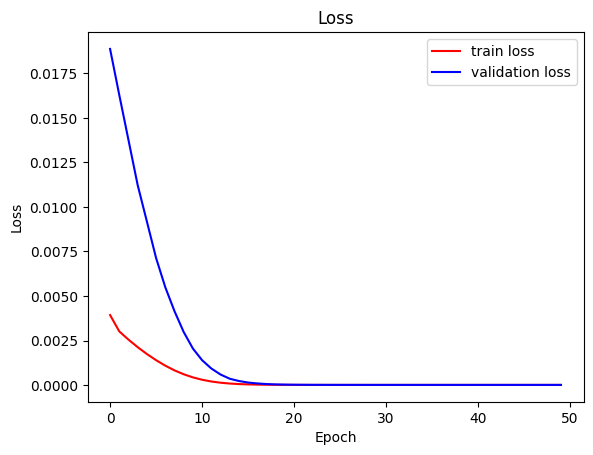

In [15]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history, color = 'red', label = 'train loss')
plt.plot(val_loss_history, color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

531/531 [==============================] - 1s 1ms/step
predicted_price shape: (16971, 1)
real_price shape: (16971, 1)


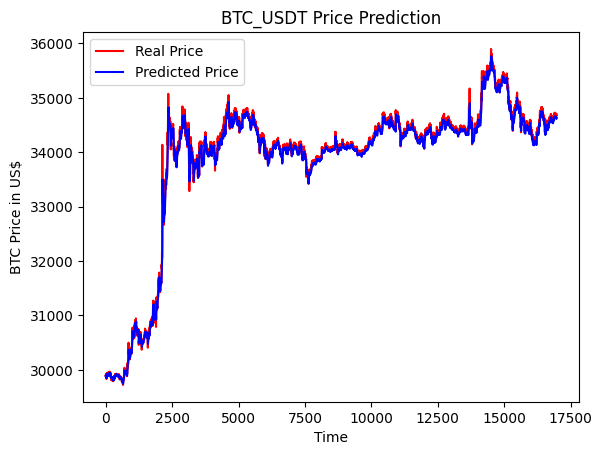

In [16]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-predicting_points]
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_test)[:-predicting_points]
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

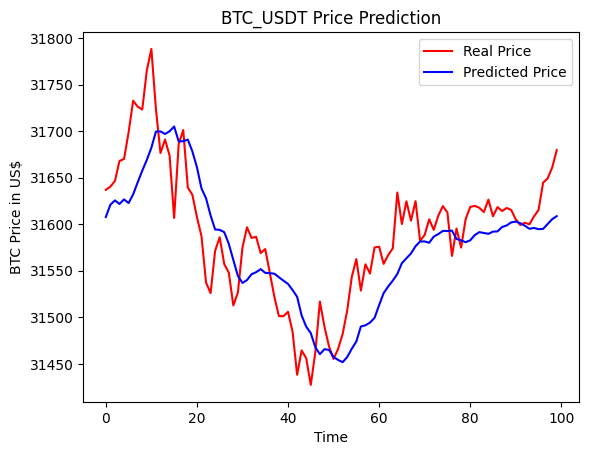

In [17]:

plt.plot(real_price[2000:2100], color = 'red', label = 'Real Price')
plt.plot(predicted_price[2000:2100], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

In [18]:
mse = metrics.mean_squared_error(real_price.reshape(real_price.shape[0]),
                   predicted_price.reshape(predicted_price.shape[0]))
print('mse:',mse)

mse: 4080.5839204505874
